# Libraries

In [1]:
import csv
import os
import json
import umap
import textacy
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pointgrid import align_points_to_grid
from sklearn.linear_model import LinearRegression

# Data

## Folder Parsing

In [2]:
# The index of these four arrays corresponds to one organization

orgs = []
texts = []
years = []
occurences = []
urls = []
lengths = []
# kind = []


# The template counts the occurencies for each organization

years_template = { 2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0, 2019: 0, 2020: 0 }


# Folder

dir = 'data/biomass/'
files = os.listdir(dir)
print('Total', len(files))

for index, filename in enumerate(files):

    # Read file
    
    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)


    # Set basic metadata

    try:

        # Counter

        if not index % 1000:
            print(index, ' | ', end=' ')

        # Collect information

        url = data[0]['url']
        records = data[0]['story_tags'] # Set tags
        length = len(records)
        year = int(data[0]['publish_date'].split(' ')[0].split('-')[0]) # Set year

        # Allow list
        
        matches = ['wsj.com', 'usatoday.com', 'nytimes.com', 'latimes.com', 'nypost.com', 'washingtonpost.com', 'startribune.com', 'chicagotribune.com', 'chron.com', 'nydailynews.com']
        if not any(x in url for x in matches): continue

        # Stop list (Bob Dylan case)
        
        matches = {'feeds.latimes.com'}
        if any(x in url for x in matches): continue

        # Max tags
        if  length > 100: continue # Limit the maxiumum number of records
        
        # Save
        
        urls.append(url)
        lengths.append(length)
        
    
    except:
        continue


    # Collect entities
    
    tags = []

    for record in records:
        
        # Filter tags
        
        matches = ['nyt_labels', 'cliff_organizations', 'cliff_people']
        tag_set = record['tag_set']

        if any(x in tag_set for x in matches):
        # if (record['tag_set'] == 'cliff_people'):
            
            tag = record['tag']

            # if len(tag) > 50:
            #     continue # Set limits to tag's length

            # if len(tag) < 4:
            #     continue # Set limits to tag's length

            tag = ' '.join(tag.split()) # Merge spaces
            tag = tag.replace('.', '')
            tag = tag.replace(',', '')
            
            if tag.startswith('US '): tag = tag[3:]
            if tag.endswith(' Corp'): tag = tag[:-5]
            if tag.endswith(' Inc'): tag = tag[:-4]
            
            
            # if tag[0].isupper() and tag[1].isupper():
            #     continue # Remove acronyms
            
            if tag[0] == ('—'):
                continue # Remove listing

            tags.append(tag)
    
    
    # Tgas cleaning

    stoplist = {'nyt_labeller_v100', 'no index terms from nytimes', 'post', 'Post', 'Google', 'Facebook', 'Amazon', 'YouTube', 'brown'}

    tags = list(filter(lambda x: not x in stoplist, tags))

    for i, tag in enumerate(tags):
        if tag == 'Xcel': tags[i] = 'Xcel Energy'

        if tag == 'Obama': tags[i] = 'Barack Obama'
        if tag == 'Trump': tags[i] = 'Donald Trump'
        if tag == 'USA TODAY': tags[i] = 'USA Today'

        if tag == 'NOAA': tags[i] = 'National Oceanic and Atmospheric Administration'
        if tag == 'EPA': tags[i] = 'Environmental Protection Agency'
        if tag == 'United States Environmental Protection Agency': tags[i] = 'Environmental Protection Agency'
        if tag == 'UN': tags[i] = 'United Nations'
        if tag == 'EC': tags[i] = 'European Commission'
        if tag == 'IEA': tags[i] = 'International Energy Agency'
        if tag == 'EU': tags[i] = 'European Union'
        if tag == 'EIA': tags[i] = 'Energy Information Administration'
        if tag == 'AP': tags[i] = 'Associated Press'
        if tag == 'ASSOCIATED PRESS': tags[i] = 'Associated Press'
        if tag == 'DOE': tags[i] = 'Department of Energy'
        if tag == 'Energy': tags[i] = 'Department of Energy'
        if tag == 'Energy Department': tags[i] = 'Department of Energy'
        if tag == 'GM': tags[i] = 'General Motors'
        if tag == 'IRS': tags[i] = 'Internal Revenue Service'
        if tag == 'GOP': tags[i] = 'Republican Party'
        if tag == 'USDA': tags[i] = 'Department of Agriculture'
        if tag == 'Agriculture Department': tags[i] = 'Department of Agriculture'
        if tag == 'TPWD': tags[i] = 'Texas Parks and Wildlife Department'
        if tag == 'DNR': tags[i] = 'Department of Natural Resources'
        if tag == 'FDA': tags[i] = 'Food and Drug Administration'
        if tag == 'OPEC': tags[i] = 'Organization of the Petroleum Exporting Countries'
        
        if tag == 'Stanford': tags[i] = 'Stanford University'
        if tag == 'Harvard': tags[i] = 'Harvard University'
        if tag == 'Yale': tags[i] = 'Yale University'
        if tag == 'Nasa': tags[i] = 'NASA'
        if tag == 'MSP': tags[i] = 'Minneapolis–Saint Paul'
        if tag == 'St Paul': tags[i] = 'Minneapolis–Saint Paul'

        if tag.startswith('University of California'): tags[i] = 'University of California'
        if tag.startswith('Columbia University'): tags[i] = 'Columbia University'

        if tag.startswith('Bloomberg'): tags[i] = 'Bloomberg'
        if tag.startswith('UBS'): tags[i] = 'UBS'
        if tag.startswith('Exxon'): tags[i] = 'Exxon'
        if tag.startswith('Drax'): tags[i] = 'Drax'
        if tag.startswith('Valens'): tags[i] = 'Valens'
        if tag.startswith('Siemens'): tags[i] = 'Siemens'
        if tag.startswith('Abengoa'): tags[i] = 'Abengoa'
        if tag.startswith('BBC'): tags[i] = 'BBC'
        if tag.startswith('New York Times'): tags[i] = 'New York Times'

        if tag.startswith('Sierra Club'): tags[i] = 'Sierra Club'
        if tag == 'Sierra': tags[i] = 'Sierra Club'


    tags = list(set(tags))
    # print(tags)


    # Create data structure

    for t in tags:

        related = tags.copy()
        related.remove(t)    
    
        if t not in orgs:
            orgs.append(t)
            i = orgs.index(t)
            texts.append(related)
            occurences.append(1)
            years.append(years_template.copy())
            years[i][year] += 1
                
        else:
            i = orgs.index(t)
            texts[i] += related
            occurences[i] += 1
            years[i][year] += 1

    # if index > 20:
    #     raise SystemExit("Stop right there!")

Total 26450
0  |  1000  |  2000  |  3000  |  4000  |  5000  |  6000  |  7000  |  8000  |  9000  |  10000  |  11000  |  12000  |  13000  |  14000  |  15000  |  16000  |  17000  |  18000  |  19000  |  20000  |  21000  |  22000  |  23000  |  24000  |  25000  |  26000  |  

## Copy

In [3]:
copy_orgs = orgs.copy()
copy_texts = texts.copy()
copy_years = years.copy()
copy_occurences = occurences.copy()

# Print

print(
    '       orgs:', len(orgs), '\n',
    '     texts:', len(texts), '\n', 
    '     years:', len(years), '\n', 
    'occurences:', len(occurences), '\n'
    'lengths:', len(lengths), '\n')


       orgs: 4905 
      texts: 4905 
      years: 4905 
 occurences: 4905 
lengths: 568 



## Google Test

In [4]:
# n = orgs.index('Google')
# print(orgs[n], '\n')
# print(texts)

## Cleaning

In [5]:
orgs = copy_orgs.copy()
texts = copy_texts.copy()
years = copy_years.copy()
occurences = copy_occurences.copy()


# Set occurrence limit

for index, occurrence in reversed(list(enumerate(occurences))):

    min = 5

    if occurrence < min:
        orgs.pop(index)
        texts.pop(index)
        years.pop(index)
        occurences.pop(index)


# Order years by key in tuples

for index, y in enumerate(years):
    sortedDict = dict( sorted(y.items(), key=lambda x: x[0]) )
    _temp = {}
    for k,v in sortedDict.items():
        _temp[k] = v
    years[index] = _temp


# Print

print(
    '       orgs:', len(orgs), '\n',
    '     texts:', len(texts), '\n', 
    '     years:', len(years), '\n', 
    'occurences:', len(occurences), '\n')


       orgs: 162 
      texts: 162 
      years: 162 
 occurences: 162 



# Analysis

## Total linear regression

In [6]:
total_years = {}

for year in years:
    # print(year)
    for k, v in year.items():
        # print(k, v)
        if k in total_years:
            total_years[k] += v
        else:
            total_years[k] = v

y = list(year.values())
x = list(year.keys())
x = np.array(x).reshape((-1, 1))

model = LinearRegression().fit(x, y)
slope = model.coef_
total_slope = slope[0]
# score = model.score(x, y)

total_years, total_slope


({2011: 423,
  2012: 372,
  2013: 328,
  2014: 313,
  2015: 451,
  2016: 457,
  2017: 313,
  2018: 364,
  2019: 342,
  2020: 263},
 -0.13939393939393935)

## Single linear regression

In [7]:
# Linear regression

import matplotlib.colors

slopes = []
colors = []

_min = 0
_max = 0


# Slope

for year in years:

    y = list(year.values())
    x = list(year.keys())
    x = np.array(x).reshape((-1, 1))
    
    model = LinearRegression().fit(x, y)
    slope = model.coef_
    slope = slope[0] - total_slope
    # slope = slope[0]
    score = model.score(x, y)
    slopes.append(slope)

    if slope > _max: _max = slope
    if slope < _min: _min = slope

    # print()
    # print(list(year.keys()), y)
    # print('slope', slope, 'score', score)

print('min', _min, 'max', _max)

# Colors

cmap = plt.cm.RdYlBu_r
cmap = plt.cm.coolwarm
# norm = matplotlib.colors.Normalize(vmin=_min, vmax=_max)
norm = matplotlib.colors.DivergingNorm(vmin=_min, vcenter=0, vmax=_max)
# norm = matplotlib.colors.DivergingNorm(vmin=-10, vcenter=0, vmax=10)

for slope in slopes:
    color = cmap(norm(slope))
    colors.append(color)


min -1.4121212121212114 max 1.236363636363636


/var/folders/lr/mmry4yv506b3rqk3bgm2s_j80000gn/T/ipykernel_17160/1608583968.py:41: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = matplotlib.colors.DivergingNorm(vmin=_min, vcenter=0, vmax=_max)


## Term Frequency

In [8]:
doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(texts, tf_type="linear", idf_type="smooth")

# Spatial Analysis

## UMAP

In [9]:
# random_state=2
# reducer = umap.UMAP(n_components=2, n_neighbors=3, min_dist=0.01, metric='cosine')
reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=.01, metric='hellinger')

embedding = reducer.fit_transform(doc_term_matrix)
# embedding = align_points_to_grid(embedding)
x = embedding[:, 0]; y = embedding[:, 1]

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Clustering

In [10]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=3, cluster_selection_epsilon=.5)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=3)
# clusterer = hdbscan.HDBSCAN(cluster_selection_epsilon=0.3, cluster_selection_method='leaf')
# min_samples is to consier all the elements that owtherwide will be classified as noise
# cluster_selection_epsilon extends clusters
clusterer.fit(embedding)
clusters = clusterer.labels_

# Grouping by cluster

values = set(clusters)
if -1 in values: values.remove(-1)

clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

len(clusters)

8

# Plotting

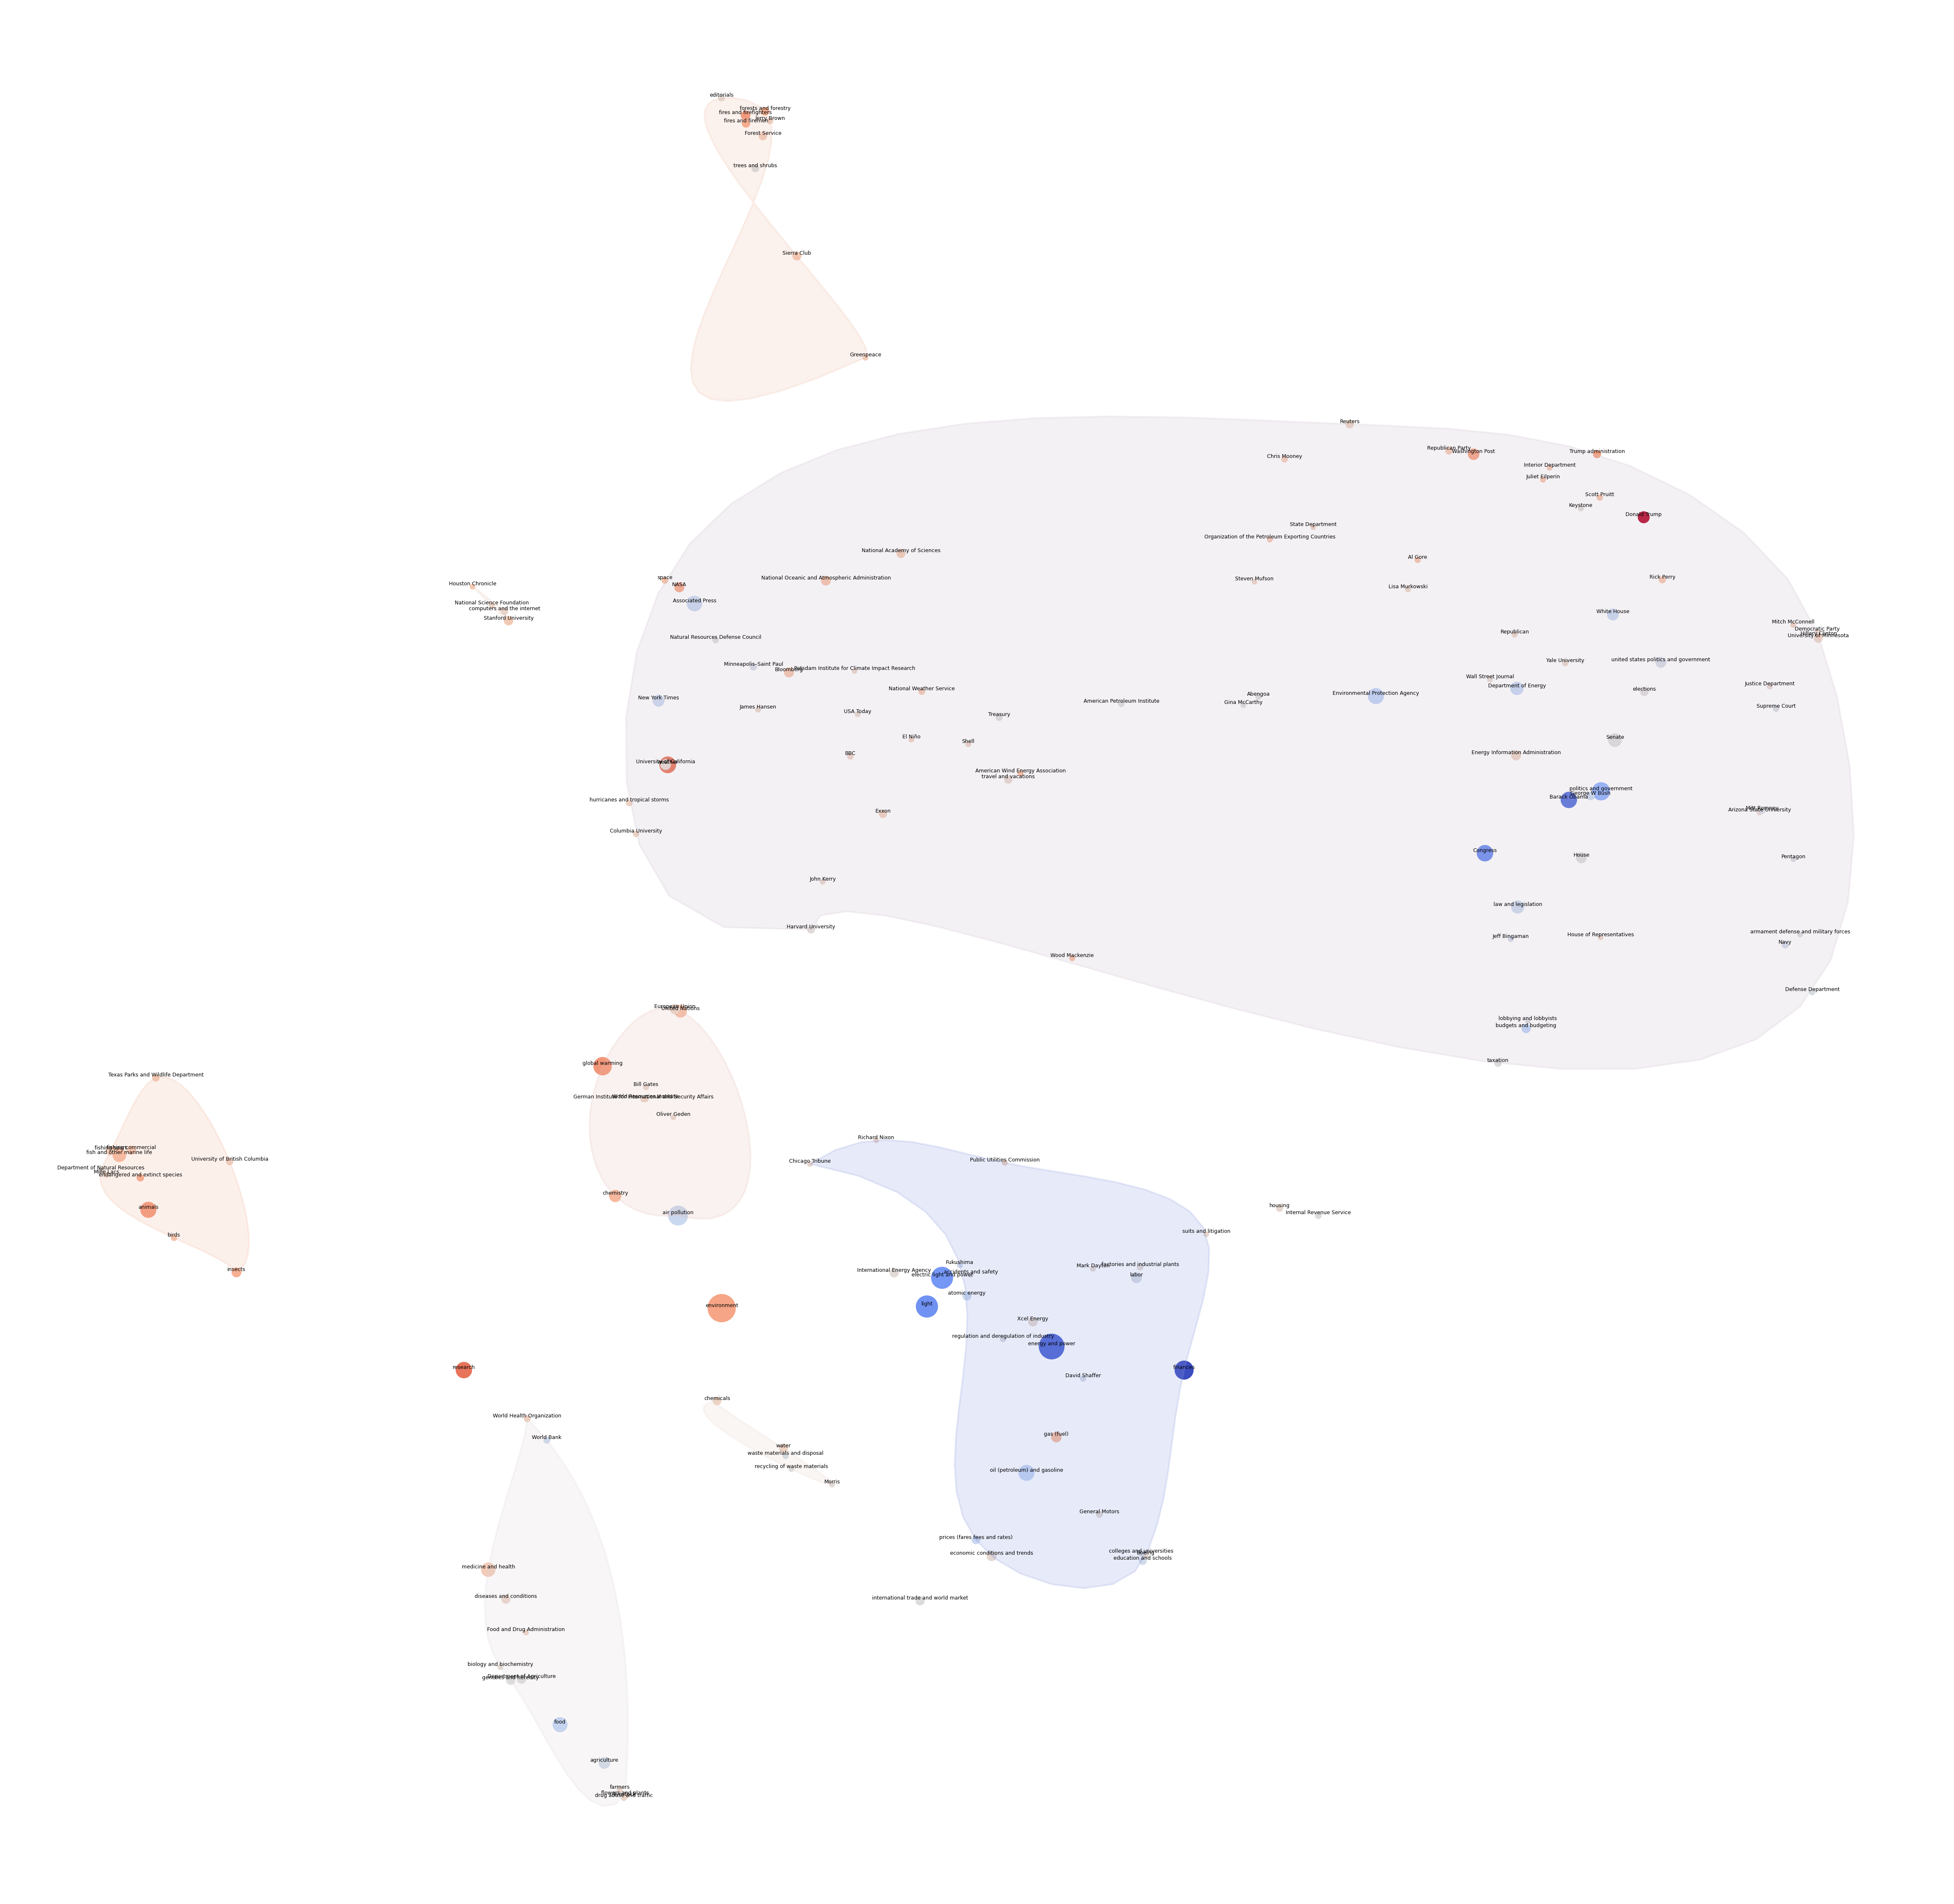

In [11]:
# Plot

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate




# Frame

plt.figure(figsize=(20,20), dpi=300)
plt.axis('off')


# Hulls

for cluster in clusters:

    # Average color
    
    background_color = []
    
    for i, index in enumerate(cluster):
        for occurence in range(occurences[index]):
            background_color.append([colors[index][0], colors[index][1], colors[index][2]])

    r = [i[0] for i in background_color]; r = sum(r) / len(r)
    g = [i[1] for i in background_color]; g = sum(g) / len(g)
    b = [i[2] for i in background_color]; b = sum(b) / len(b)

    background_color = (r, g, b, 1)

    # Hull

    points = []
    for index in cluster:
        points.append([embedding[index][0], embedding[index][1]])
    points = np.array(points)

    # print(points)

    hull = ConvexHull(points)
    
    x_hull = np.append(points[hull.vertices,0], points[hull.vertices,0][0]) # Collect the xs + first x
    y_hull = np.append(points[hull.vertices,1], points[hull.vertices,1][0])

    # print(x_hull)

    # break
    
    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)
    
    # plot shape
    plt.fill(interp_x, interp_y, '--', c=background_color, alpha=.2)


# Scatterplot

plt.scatter(x, y, s=occurences, c=colors)
# plt.scatter(x, y, s=40, c=colors)


# Labels

for i, txt in enumerate(orgs):
    # text = plt.annotate(orgs[i], xy=(x[i], y[i] - math.sqrt(occurences[i]/math.pi)/40), ha='center', va='bottom')
    text = plt.annotate(orgs[i], xy=(x[i], y[i]), ha='center', va='bottom')
    text.set_fontsize(3)

plt.savefig('/Users/dario/Desktop/download.png')
plt.savefig('download.png')

# Saving files

In [12]:
with open('orgs.csv', 'w', encoding='UTF8') as f:
    for n in orgs:
        i = orgs.index(n)
        f.write(n + "," + str(occurences[i]) + '\n')

with open('urls.csv', 'w', encoding='UTF8') as f:
    for n in urls:
        i = urls.index(n)
        f.write(str(urls[i]) + '\n')

with open('lengths.csv', 'w', encoding='UTF8') as f:
    for n in lengths:
        i = lengths.index(n)
        f.write(str(lengths[i]) + '\n')

with open('src/data/embedding.csv', 'w', encoding='UTF8') as f:
    f.write('x,y\n')
    for element in embedding:
        f.write(str(element[0]) + ',' + str(element[1]) + '\n')

with open('src/data/weights.csv', 'w', encoding='UTF8') as f:
    f.write('weight\n')
    for element in occurences:
        f.write(str(element) + '\n')

with open('src/data/names.csv', 'w', encoding='UTF8') as f:
    f.write('name\n')
    for element in orgs:
        f.write(str(element) + '\n')
        

In [13]:
embedding[0][0]

11.516372